In this example we will see how to plot an hexagonal map that reflects the results of the training process. This example is an extension of BasicUsage.ipynb. Only the plotting section has new code.

In [6]:
from minisom import MiniSom

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.lines import Line2D

# display matplotlib plots in notebook
%matplotlib inline
# display bokeh plot in notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Load, Preprocess and Training

We load the seeds dataset, normalise the data along the columns and then train our SOM.

In [7]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00236/seeds_dataset.txt', 
                   names=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                          'asymmetry_coefficient', 'length_kernel_groove', 'target'], 
                   sep='\t+')
t = data['target'].values
data = data[data.columns[:-1]]

# data normalization
data = (data - np.mean(data, axis=0)) / np.std(data, axis=0)
data = data.values

# initialization and training of 15x15 SOM
som = MiniSom(15, 15, data.shape[1], sigma=1.5, learning_rate=.7, activation_distance='euclidean',
              topology='hexagonal', neighborhood_function='gaussian', random_seed=10)

som.train(data, 1000, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


 [  685 / 1000 ]  68% - 0:00:00 left 

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.34742730287407053


***

## Plotting: matplotlib

Below, we are plotting using matplotlib to visualize the results on a hexagonal map.

In [8]:
xx, yy = som.get_euclidean_coordinates()
umatrix = som.distance_map()
weights = som.get_weights()

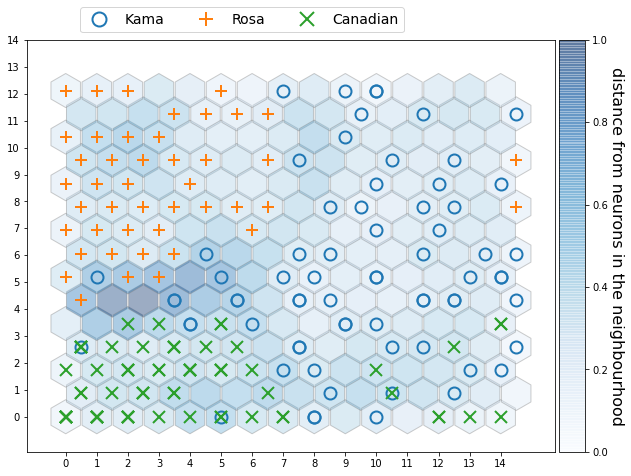

In [9]:
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111)

ax.set_aspect('equal')

# iteratively add hexagons
for i in range(weights.shape[0]):
    for j in range(weights.shape[1]):
        wy = yy[(i, j)] * np.sqrt(3) / 2
        hex = RegularPolygon((xx[(i, j)], wy), 
                             numVertices=6, 
                             radius=.95 / np.sqrt(3),
                             facecolor=cm.Blues(umatrix[i, j]), 
                             alpha=.4, 
                             edgecolor='gray')
        ax.add_patch(hex)

markers = ['o', '+', 'x']
colors = ['C0', 'C1', 'C2']
for cnt, x in enumerate(data):
    # getting the winner
    w = som.winner(x)
    # place a marker on the winning position for the sample xx
    wx, wy = som.convert_map_to_euclidean(w) 
    wy = wy * np.sqrt(3) / 2
    plt.plot(wx, wy, 
             markers[t[cnt]-1], 
             markerfacecolor='None',
             markeredgecolor=colors[t[cnt]-1], 
             markersize=12, 
             markeredgewidth=2)

xrange = np.arange(weights.shape[0])
yrange = np.arange(weights.shape[1])
plt.xticks(xrange-.5, xrange)
plt.yticks(yrange * np.sqrt(3) / 2, yrange)

divider = make_axes_locatable(plt.gca())
ax_cb = divider.new_horizontal(size="5%", pad=0.05)    
cb1 = colorbar.ColorbarBase(ax_cb, cmap=cm.Blues, 
                            orientation='vertical', alpha=.4)
cb1.ax.get_yaxis().labelpad = 16
cb1.ax.set_ylabel('distance from neurons in the neighbourhood',
                  rotation=270, fontsize=16)
plt.gcf().add_axes(ax_cb)

legend_elements = [Line2D([0], [0], marker='o', color='C0', label='Kama',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='+', color='C1', label='Rosa',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2),
                   Line2D([0], [0], marker='x', color='C2', label='Canadian',
                   markerfacecolor='w', markersize=14, linestyle='None', markeredgewidth=2)]
ax.legend(handles=legend_elements, bbox_to_anchor=(0.1, 1.08), loc='upper left', 
          borderaxespad=0., ncol=3, fontsize=14)

plt.savefig('resulting_images/som_seed_hex.png')
plt.show()